In [19]:
import numpy as np
import gym
from gym.spaces import Discrete, Box
import torch.nn as nn
import torch
import torch.optim as optimizer
import torch.nn.functional as F
import matplotlib.pyplot as plt


class MLP(nn.Module):
    """
    Returns a fully connected neural network of 
    given dimensions. The input is of dimensions
    of the shape of the observations and output
    is of the shape of number of actions.
    """

    def __init__(self, sizes, activation=nn.ReLU(inplace=True), output_activation=None):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if i < len(sizes) - 2:
                layers.append(activation)
        self.fwd = nn.Sequential(*layers)
    
    def forward(self, x):
        return F.softmax(self.fwd(x), dim=-1)

def discount_rewards(rewards, gamma=0.99):
    # Cumulative discounted sum
    r = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
    r = r[::-1].cumsum()[::-1]
    # Subtracting the baseline reward 
    # Intuitively this means if the network predicts what it
    # expects it should not do too much about it
    # Stabalizes and speeds up the training 
    return r - r.mean()

def train(env_name='CartPole-v0', num_episodes=800, batch_size=10, lr=0.01, gamma=0.99):

    env = gym.make(env_name)
    model = MLP([env.observation_space.shape[0], 32, 20, env.action_space.n])
  
    # Lists for maintaing logs
    total_rewards = []
    batch_rewards = []
    batch_actions = []
    batch_states = []
    total_loss=[]
    batch_counter = 1
    opt = optimizer.Adam(model.parameters(), lr)
    action_space = np.arange(env.action_space.n)
    
    for ep in range(num_episodes):
        # Reset
        
        s_0 = env.reset()
        states = []
        rewards = []
        actions = []
        train_loss=[]
        complete = False
        while complete == False:
            action_probs = model(torch.FloatTensor(s_0)).detach().numpy()
            action = np.random.choice(action_space, p=action_probs)
            s1, r, complete, _ = env.step(action)
            states.append(s_0)
            rewards.append(r)
            actions.append(action)
          
            s_0 = s1
            if complete:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_counter += 1
                total_rewards.append(sum(rewards))
                
                
                if batch_counter == batch_size:
                    # Prepare the batches for training
                    # Add states, reward and actions to tensor
                    opt.zero_grad()
                    state_tensor = torch.FloatTensor(batch_states)
                    reward_tensor = torch.FloatTensor(batch_rewards)
                    action_tensor = torch.LongTensor(batch_actions)

                    # Convert the probs by the model to log probabilities
                    log_probs = torch.log(model(state_tensor))
                    # Mask the probs of the selected actions
                    selected_log_probs = reward_tensor * log_probs[np.arange(len(action_tensor)), action_tensor]
                    # Loss is negative of expected policy function J = R * log_prob
                    loss = -selected_log_probs.mean()
                    train_loss.append(loss.item())
                    
                    # Do the update gradient descent(with negative reward hence is gradient ascent) 
                    loss.backward()
                    opt.step()
                    
                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1

                print("\rEp: {} Average of last 10: {:.2f}".format(
                    ep + 1, np.mean(total_rewards[-10:])), end="")
        total_loss.append(sum(train_loss))
    return total_rewards,total_loss

if __name__ == '__main__':

    rewards,trainloss= train()
    
   

Ep: 800 Average of last 10: 200.00

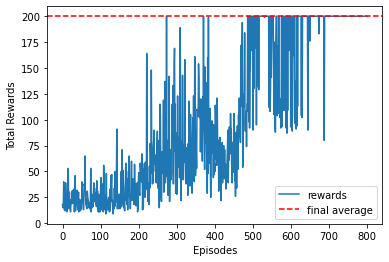

In [20]:
plt.plot(rewards,label='rewards')
plt.axhline(y=np.mean(np.array(rewards)[-100:]),color="r",linestyle='--',label='final average')
plt.ylabel('Total Rewards')
plt.xlabel('Episodes')
plt.legend()
plt.show()
    


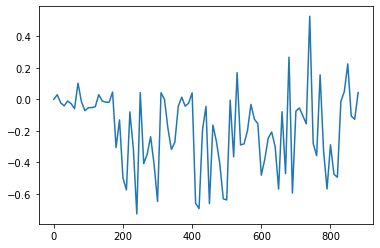

In [30]:
trainloss = list(set(trainloss))
plt.plot(np.array(range(0,890,10)),trainloss)